In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import read_process_data

from keras import layers, losses, models, preprocessing

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data_path = 'data'
train_csv = data_path + '/train.csv'
test_csv  = data_path + '/test.csv'

contractions_csv = data_path + '/contractions.csv'

dict_sent_to_label = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

In [3]:
df_train = read_process_data(train_csv, True, False, contractions_csv, True)
df_test  = read_process_data(test_csv , True, False, contractions_csv, True)

In [4]:
df_data = pd.concat([df_train, df_test])
list_texts = df_data["text_preprocessed"].values.tolist()
vocabulary = set([word for text in df_train["text_preprocessed"].values.tolist() for word in text.split()])

SEQUENCE_LENGTH = max([len(text.split()) for text in list_texts])
MAX_FEATURES = 1500 # len(vocabulary) // 10
NUM_EMOTIONS = len(df_data["sentiment"].unique())
BATCH_SIZE = 44
EPOCHS = 10

In [5]:
def one_hot_encode(label):
    return [1 if idx == label else 0 for idx in range(NUM_EMOTIONS)]

In [6]:
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(df_train["text_preprocessed"].values)
X_train = tokenizer.texts_to_sequences(df_train["text_preprocessed"].values)
X_test  = tokenizer.texts_to_sequences(df_test["text_preprocessed"].values)

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post')
X_test  = preprocessing.sequence.pad_sequences(X_test , maxlen=SEQUENCE_LENGTH, padding='post', truncating='post')

In [7]:
df_train["label"] = df_train["sentiment"].replace(dict_sent_to_label)
df_train["label_ohe"] = df_train["label"].apply(one_hot_encode)
y_train = np.array(df_train["label_ohe"].values.tolist())

df_test["label"] = df_test["sentiment"].replace(dict_sent_to_label)
df_test["label_ohe"] = df_test["label"].apply(one_hot_encode)
y_test = np.array(df_test["label_ohe"].values.tolist())

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=len(X_test) / len(X_train), shuffle=True)

In [9]:
print(len(X_train), len(y_train), len(X_validation), len(y_validation), len(X_test), len(y_test))

23849 23849 3519 3519 3519 3519


In [10]:
model = models.Sequential([
    layers.Embedding(MAX_FEATURES, 128, input_length=SEQUENCE_LENGTH),
    layers.SpatialDropout1D(0.4),
    layers.LSTM(units=196, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(units=NUM_EMOTIONS, activation='softmax')
])

print(model.summary())

model.compile(loss=losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    verbose=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 128)           192000    
                                                                 
 spatial_dropout1d (Spatial  (None, 22, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 447391 (1.71 MB)
Trainable params: 447391 (1.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Epoch 1/10


542/542 - 37s - loss: 0.8612 - accuracy: 0.6024 - val_loss: 0.7650

In [12]:
results = model.evaluate(X_test, y_test)

110/110 [==============================] - 1s 8ms/step - loss: 0.7051 - accuracy: 0.7138


In [13]:
def plot_graphs(train_stats, val_stats, category):
    plt.plot(train_stats, label='Train ' + category)
    plt.plot(val_stats, label='Validation ' + category)

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.title(category.title())
    plt.show()

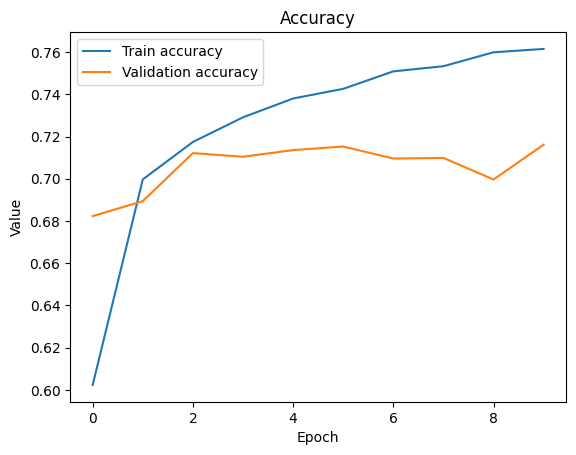

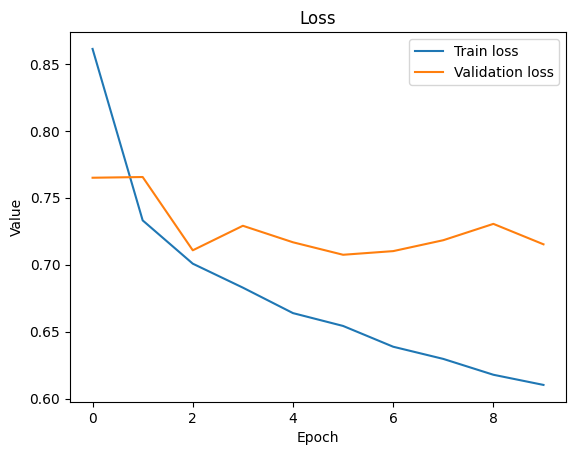

In [14]:
for category in ['accuracy', 'loss']:
    plot_graphs(history.history[category], history.history['val_' + category], category)